# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import sys
import math
import copy
import itertools
sys.path.append('../')
import iads as iads
from iads import LabeledSet as ls
from iads import Classifiers as cl
from iads import util_iads as ui
from iads import utils as ut
from iads import engineering as en
from iads import kmoyennes as km
from iads import cluster as ct
from iads import multiClassClassifier as mcl
from iads import regression as re
from iads import pb as pb

## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens
#movies = pd.read_csv("data/ml-20m/movies.csv", encoding='utf8')
movies = pd.read_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8', index_col=0)
links = pd.read_csv("data/ml-20m/links.csv", encoding='utf8')
ratings = pd.read_csv("data/ml-20m/ratings.csv", encoding='utf8')
tags = pd.read_csv("data/ml-20m/tags.csv", encoding='utf8')
genomeS = pd.read_csv("data/ml-20m/genome-scores.csv", encoding='utf8')
genomeT = pd.read_csv("data/ml-20m/genome-tags.csv", encoding='utf8')

In [3]:
# Chargement des données complémentaires
acteurs = pkl.load(open("data/act_v2.pkl", "rb"))
equipes = pkl.load(open("data/crew_v2.pkl", "rb"))
films = pkl.load(open("data/film_v2.pkl", "rb"))

<h2>Filtrage des données</h2>

In [5]:
"""
print("BEFORE")
print(len(movies))
#print(len(films))
moviesFilter = []
filmId = []
cpt = 0
for i in range(len(films)):
    filmId.append(films[i]["id"])
    
for i in range(len(movies)):
    line = links.loc[links['movieId'] == movies.iloc[i]["movieId"]]
    value = float(line.iloc[0]["tmdbId"])
    if(math.isnan(value)):
        cpt += 1
        continue
    if(value in filmId):
        moviesFilter.append(movies.iloc[i]["movieId"])
    else:
        cpt += 1
movies = movies[movies.movieId.isin(moviesFilter)]
links = links[links.movieId.isin(moviesFilter)]
ratings = ratings[ratings.movieId.isin(moviesFilter)]
print("\nAFTER")
print(len(movies))
movies.to_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8')
"""

'\nprint("BEFORE")\nprint(len(movies))\n#print(len(films))\nmoviesFilter = []\nfilmId = []\ncpt = 0\nfor i in range(len(films)):\n    filmId.append(films[i]["id"])\n    \nfor i in range(len(movies)):\n    line = links.loc[links[\'movieId\'] == movies.iloc[i]["movieId"]]\n    value = float(line.iloc[0]["tmdbId"])\n    if(math.isnan(value)):\n        cpt += 1\n        continue\n    if(value in filmId):\n        moviesFilter.append(movies.iloc[i]["movieId"])\n    else:\n        cpt += 1\nmovies = movies[movies.movieId.isin(moviesFilter)]\nlinks = links[links.movieId.isin(moviesFilter)]\nratings = ratings[ratings.movieId.isin(moviesFilter)]\nprint("\nAFTER")\nprint(len(movies))\nmovies.to_csv("data/ml-20m/moviesFiltree.csv", encoding=\'utf8\')\n'

<h2>Visionnage des données</h2>

In [6]:
#links
#ratings
#tags
#genomeS
#genomeT
#movies
#films[9]
#acteurs[0]
#equipes[0][194]

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [4]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
ue = en.UtilsEngineering(films, (acteurs, equipes))
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Total"], "films")
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Comedy"], "comédies")

UtilsEngineering init in process
UtilsEngineering init successful
Tom Hanks à joué dans 57 films
Tom Hanks à joué dans 33 comédies


# Présentation du traitement
<strong><font color="blue">[P]</font></strong> = Protocole<br/>
<strong><font color="green">[Q]</font></strong> = Question<br/>
<strong><font color="green">[A]</font></strong> = Réponse<br/>
<strong><font color="orange">[E]</font></strong> = Exploitation des données<br/>
<strong><font color="purple">[R]</font></strong> = Approfondissement<br/>
<strong><font color="red">[C]</font></strong> = Critique<br/>
## Mise en situation
Notre entreprise de traitement de données nommée <strong>Kerneloud</strong> veut se faire un nom dans le milieu de la data science afin d'attirer les VC's de la sillicon valley à Paris.
Pour cela Kerneloud va viser le secteur du divertissement multimédia pour faire ses preuves.<br/>

<strong><font color="green">[Q]</font></strong> Pourquoi le milieu du divertissement ?<br/>
<strong><font color="green">[A]</font></strong> Le budget ne permet que de se constituer d'une base de donnée..

## Genres predictions
Pour commencer Kerneloud veut publier un article afin de predire si une categorie sera rentable à partir des données des anciens films récoltés<br/>

<strong><font color="blue">[P]</font></strong> Faire un dataframe sur les categories, leur quantites de films et leur engagements puis le tester sur des classifiers afin de prédire la note moyenne des films de la categorie

<strong><font color="green">[Q]</font></strong> A partir de quoi est défini une bonne catégorie ?<br/>
<strong><font color="green">[A]</font></strong> La médianne de la note moyenne d'une catégorie sert de temoin pour définir une bonne catégorie

<strong><font color="green">[Q]</font></strong> Pourquoi la médianne à été choisie ?<br/>
<strong><font color="green">[A]</font></strong> Cela permet d'équilibrer les données vu le peu de catégories pouvant etre utilisé (le budget..)

In [7]:
#ge = en.GenresEngineering(movies,(links, films))
#df = ge.toDataFrame()
#df.to_csv("data/engineering/genres.csv", encoding='utf8')
df = pd.read_csv("data/engineering/genres.csv", encoding='utf8', index_col=0)
df

,quantite,engagement,target
Adventure,0.160587,0.653805,-1
Animation,0.061394,0.234012,1
Children,0.072183,0.259724,-1
Comedy,0.625427,0.784191,-1
Fantasy,0.091354,0.347602,-1
Romance,0.299752,0.376248,-1
Drama,1.000000,1.000000,1
Action,0.253648,0.841496,-1
Crime,0.209329,0.394125,1
Thriller,0.305107,0.692253,-1


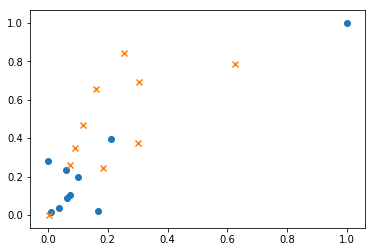

In [8]:
une_base = ls.LabeledSet(2)
for i in range(len(df)):
    une_base.addExample([df.iloc[i]['quantite'], df.iloc[i]['engagement']], df.iloc[i]['target'])
ut.plot2DSet(une_base)

No handles with labels found to put in legend.


Mean accuracy 63.6666666666667
Variance accuracy 181.27777777777777


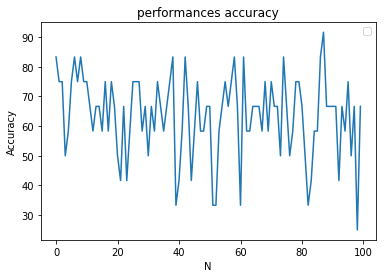

(63.6666666666667, 181.27777777777777)

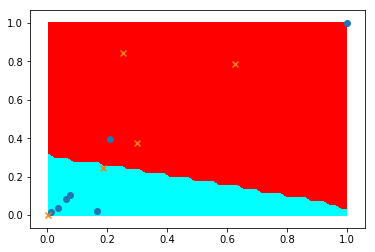

In [9]:
#ut.affiche_base(une_base)
knn = cl.ClassifierKNN(une_base.getInputDimension(), 3)
ut.super_entrainement(100, une_base, knn, 40)

<strong><font color="orange">[E]</font></strong> On obtient un classifier avec une précision un peu près abordable. Cela est en parti du au fait qu'on préfère s'entrainer sur une minorité de données. Vu la disposition des données ici qui sont entrelacées et non démarquées par une frontiere, le Knn semble être un bon choix.
On peut donc prédire quand une catégorie ou une de ses sous categories de film sera rentable grace à sa quantité de films et l'engagement que les utilisateurs lui ont accordé. 

<strong><font color="red">[C]</font></strong> Il y a tres peu de données ici, il faudrait plus de catégories et de sous categories pour que le travail soit efficace. De plus le plus gros du travail s'effectue dans la création du dataframe, cela est donc très couteux en temps. Le problème traité ici pourrait etre résolu avec de la programmation linéaire. Enfin il y a peut être une corrélation entre l'engagement des utilisateurs et la note obtenue, il faudrait donc choisir d'autres arguments pour départager les différentes catégories

<strong><font color="purple">[R]</font></strong> On pourrait rajouter des dimensions afin de mieux départager les catégories et ainsi gagner en précision. On pourrait entrainer d'autres classifiers et prendre celui avec la meilleure précision.

## Movies prediction
Le premier article publié par les docteurs de <strong>kerneloud</strong> à eu un succès régional de par sa simplicité à traiter et vulgariser un problème et cela leur à permis d'avoir des financements de la part des investisseurs de <strong>station E</strong>.<br/>
Des investisseurs et producteurs venus de Cannes voudraient exporter le cinéma français à l'international et pour cela ils voudraient les ingrédients pour avoir un bon film.
    
<strong><font color="blue">[P]</font></strong> Faire un dataFrame sur les films, leur genre, le nombre de votes qu'ils ont reçuent, leur langue originale, la note moyenne des films dans lesquels les acteurs principaux ont joués et leur popularité afin de predire leur note et leur langue et de voir quel critères sont les plus importants pour démarquer la réussite du film

In [5]:
me = en.MoviesEngineering(films, (ue.plays, ue.actorsMeanMovies, ue.languages, equipes, ue.prop_women_actors, ue.prop_women_crew))

MoviesEngineering init in process
MoviesEngineering init successful


In [8]:
df = me.toDataFrame(withTarget=False, toStack=["note"])
df

stack original_language
stack note


,vote_count,mean_main_actors,popularity,month_release,nb_producers,nb_words_overview,prop_women_actors,prop_women_crew,original_language,note
Toy Story,0.453466,0.653343,0.428418,0.846154,0.097561,0.263441,0.153846,0.046154,en,7.9
Jumanji,0.265622,0.652299,0.055441,1.000000,0.121951,0.354839,0.187500,0.106383,en,7.1
Grumpier Old Men,0.006648,0.633164,0.114305,1.000000,0.048780,0.295699,0.428571,0.080000,en,6.5
Waiting to Exhale,0.002612,0.604392,0.054876,1.000000,0.121951,0.236559,0.285714,0.142857,en,6.1
Father of the Bride Part II,0.013675,0.605705,0.128245,0.230769,0.024390,0.311828,0.416667,0.285714,en,6.1
Heat,0.142545,0.333967,0.257092,1.000000,0.097561,0.263441,0.246154,0.109589,en,7.8
Sabrina,0.012346,0.688355,0.116205,1.000000,0.097561,0.150538,0.491228,0.226415,en,6.1
Tom and Huck,0.003466,0.582065,0.067104,1.000000,0.000000,0.317204,0.428571,0.000000,en,5.3
Sudden Death,0.013248,0.598221,0.110806,0.846154,0.146341,0.225806,0.166667,0.077778,en,5.7
GoldenEye,0.087987,0.620224,0.312834,0.923077,0.097561,0.139785,0.333333,0.130435,en,6.8


No handles with labels found to put in legend.


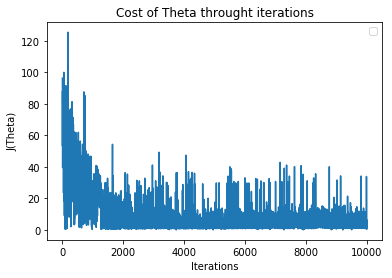

6.207978742903843
[[4.54426243]
 [3.37484487]]


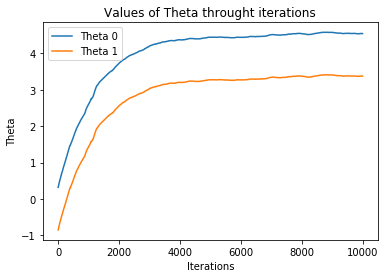

In [22]:
lms = re.GradientBatch(7,0.7)
lTrain = ls.LabeledSet(3)
for index, row in df[:10000].iterrows():
    inter = []
    inter.append(row["vote_count"])
    inter.append(row["popularity"])
    inter.append(row["mean_main_actors"])
    lTrain.addExample(inter, row["note"])
lms.train(lTrain, True)

In [20]:
lTest = ls.LabeledSet(3)
for index, row in df[10001:].iterrows():
    inter = []
    inter.append(row["vote_count"])
    inter.append(row["popularity"])
    inter.append(row["mean_main_actors"])
    lTest.addExample(inter, row["note"])

In [23]:
lms.accuracy(lTest)

54.62826048382327

<strong><font color="orange">[E]</font></strong> Les résultats obtenuent pour déterminer la note du film sont plutot convainquancs. En rajoutant d'autres critères à l'avenir on pourra réduire le seuil d'erreur.

In [36]:
dataHeight = 500
"""
Fonction qui initialise un multiClassClassifier
avec un dataFrame et ses labels correspondants
engineering: Engineering, les données traites
classifier: Classifier, initialisé sans entrainement
label: String, colonne du dataframe pour définir les differentes classes
n: int, nombre d'entrainement que chaque classifier fera
"""
def initMultiClassClassifier(engineering, classifier, label, n):
    temoins = set(engineering.df[label])
    mcClassifier = mcl.MultiClassClassifier()
    for l in temoins:
        df = engineering.toDataFrame("vs", label, l)
        labSet = ls.LabeledSet(len(list(df))-1)
        for index, row in df[-dataHeight:].iterrows():
            inter = []
            for k in row.keys():
                if k != "target":
                    inter.append(row[k])
            labSet.addExample(inter, row["target"])
        c = copy.deepcopy(classifier)
        ut.entrainement(n, labSet, c)
        mcClassifier.add(l, c)
    return mcClassifier

In [27]:
perceptron = cl.ClassifierPerceptronKernel(6, 0.05, cl.KernelPoly())
clMulti = initMultiClassClassifier(me, perceptron, "original_language", 100)

multiClassClassifier init
vs bo
Mean accuracy 100.0
Variance accuracy 0.0
vs 
Mean accuracy 100.0
Variance accuracy 0.0
vs eo
Mean accuracy 100.0
Variance accuracy 0.0
vs mn
Mean accuracy 100.0
Variance accuracy 0.0
vs de
Mean accuracy 79.675
Variance accuracy 393.8918749999999
vs mr
Mean accuracy 100.0
Variance accuracy 0.0
vs sh
Mean accuracy 99.985
Variance accuracy 0.0072750000000000046
vs pa
Mean accuracy 99.56
Variance accuracy 0.6464000000000002
vs ro
Mean accuracy 99.64
Variance accuracy 0.1204
vs cy
Mean accuracy 99.99
Variance accuracy 0.004899999999999999
vs et
Mean accuracy 99.995
Variance accuracy 0.002474999999999998
vs tg
Mean accuracy 100.0
Variance accuracy 0.0
vs ab
Mean accuracy 100.0
Variance accuracy 0.0
vs cn
Mean accuracy 99.105
Variance accuracy 0.601475
vs bm
Mean accuracy 100.0
Variance accuracy 0.0
vs ky
Mean accuracy 99.735
Variance accuracy 0.08227499999999999
vs ay
Mean accuracy 99.995
Variance accuracy 0.002474999999999998
vs sr
Mean accuracy 99.71
Varian

In [37]:
df = me.toDataFrame(withTarget=False)

labelTest = ls.LabeledSet(len(list(df))-1)
for index, row in df[-dataHeight:].iterrows():
    inter = []
    for k in row.keys():
        if k != "original_language":
            inter.append(row[k])
    labelTest.addExample(inter, row["original_language"])
    
unique_elements, counts_elements = np.unique([me.df["original_language"][-dataHeight:]], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

stack original_language
Frequency of unique values of the said array:
[['ar' 'bg' 'cn' 'da' 'de' 'el' 'en' 'es' 'fa' 'fi' 'fr' 'gl' 'hi' 'it'
  'ja' 'ko' 'ky' 'lv' 'nl' 'no' 'pa' 'pl' 'pt' 'ro' 'ru' 'sl' 'sr' 'sv'
  'ta' 'te' 'tl' 'tr' 'xx' 'zh']
 ['1' '1' '3' '3' '56' '8' '251' '10' '1' '5' '52' '1' '3' '37' '15' '4'
  '1' '1' '4' '2' '1' '5' '3' '1' '7' '4' '1' '9' '1' '1' '2' '2' '2' '2']]


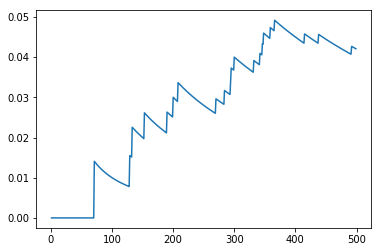

In [29]:
x=[]
y=[]
bon=0
for i in range(1, int(dataHeight)):
    x.append(i)
    if clMulti.predict(labelTest.getX(i)) == labelTest.getY(i)[0]:
        bon+=1
    y.append(bon/i)
plt.plot(x, y)
plt.show()

<strong><font color="orange">[E]</font></strong> On peut maintenant prédire quel langue sera adapté à la region des films selectionnés. Cet outils pourra être réutilisé pour prédire quel genre sera le mieux adapté

<strong><font color="red">[C]</font></strong> Ici les données sont désiquilibrées donc cela fausse l'entrainement des classifiers

Déterminons les critères qui peuvent démarquer un bon film

<strong><font color="blue">[P]</font></strong> Faire s'entraîner le classifier sur le même dataframe en faisant varier les combinaisons possibles de paramètres tout en s'entrainant sur la même partie de la base.

In [ ]:
df = me.toDataFrame("mean",toStack=['nb_producers', 'nb_words_overview', 'month_release'])
pb.bestCriteria(df,['vote_count', 'mean_main_actors','popularity', 'prop_women_actors', 'month_release', 'nb_producers', 'nb_words_overview'])

<strong><font color="orange">[E]</font></strong> Cette fonction nous permet de trouver les critères les plus adaptés à notre question, c'est pourquoi nous avons choisi de travailler uniquement sur une base contenant des films français. On voit ici que les paramètres qui nous permettent d'avoir la meilleure moyenne d'accuracy et le moindre écart-type sont la moyenne des acteurs principaux qui jouent dans le film et le nombre de vote total.

<strong><font color="red">[C]</font></strong> On remarque qu'il ne suffit pas d'augmenter le nombre de paramètres pour augmenter la précision sur ce problème. Toutefois, on voit que certains paramètres entrainent une similiraité dans la précision de la classification.

<strong><font color="purple">[R]</font></strong> On peu également rajouter divers paramètres sur d'autres dimensions tels que prendre le réalisateur du film, les membres de l'équipe de ce dernier..

## Genres Cluster
La dernière collaboration des chercheurs de <strong>Kerneloud</strong> leur à permis de se faire connaître à l'interational et de recevoir des financements d'investisseurs d'un peu partout dans le monde. Tous ce travail à permis d'attirer une entreprise de Neverllywood, <strong>Werner Bros</strong>. La compagnie <strong>WB</strong> peine à produire ses résultats trimestrielles et pour cela elle voudrait se relancer en produisant un film qui touche la plus large gamme de public possible.

<strong><font color="blue">[P]</font></strong> Faire un dataFrame sur les genres et les films qui y sont pour déterminer les genres similaires grâce aux centroides du cluster

In [6]:
gce = en.GenresClusterEngineering(films)
df = gce.toDataFrame(withTarget=False)
df

GenreClusterEngineering init in process
GenreClusterEngineering init successful


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Toy Story,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heat,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Sabrina,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Tom and Huck,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sudden Death,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GoldenEye,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
"""
Fonction qui permet de visualiser les distances
entre 2 dimension d'un dataFrame
df: DataFrame, dataFrame à visionner
x: String, nom d'une colonne du dataFrame
y: String, nom d'une colonne du dataFrame
"""
def compareCentroide(df, x, y):
    dfBis = df[[x, y]][:1000]
    dfBis = dfBis.rename({x:"X", y:"Y"}, axis='columns')
    centroide, matrice = km.kmoyennes(3, dfBis, 0.005, 1000)
    km.affiche_resultat(dfBis,centroide,matrice)
    return centroide, matrice

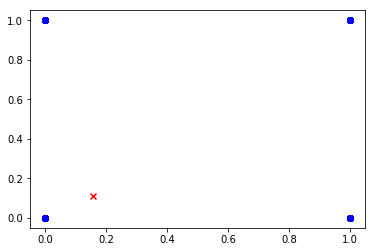

In [13]:
centroide2d, matrice2d = compareCentroide(df, "Action", "Adventure")
centroide, matrice = km.kmoyennes(20, df[:500], 0.05, 1000)

In [14]:
centroide2d = centroide2d.dropna()
centroide = centroide.dropna()

In [15]:
print(centroide2d)
#print(matrice2d)
print("\n_____________________________________________FROM__2D__TO__20D___________________________________________________\n")
print(centroide)
#print(matrice)

       X      Y
0  0.156  0.113

_____________________________________________FROM__2D__TO__20D___________________________________________________

      Action  Adventure  Animation    Comedy     Crime  Documentary     Drama  \
0   0.333333   0.000000   0.000000  0.037037  0.074074          0.0  0.037037   
1   0.607143   0.142857   0.000000  0.928571  0.750000          0.0  0.035714   
2   0.000000   0.000000   0.000000  1.000000  0.000000          0.0  1.000000   
3   0.000000   0.000000   0.000000  1.000000  0.000000          0.0  0.000000   
4   0.044444   0.000000   0.000000  0.000000  0.200000          0.0  1.000000   
5   0.018868   0.056604   0.000000  0.000000  0.056604          0.0  0.981132   
6   0.052632   0.026316   0.000000  1.000000  0.078947          0.0  1.000000   
7   0.222222   0.518519   0.185185  0.000000  0.000000          0.0  0.666667   
9   0.153846   0.230769   0.038462  1.000000  0.000000          0.0  0.346154   
11  0.037037   0.037037   0.037037  1.0000

In [16]:
M_Fusion = ct.clustering_hierarchique(centroide, "manhattan")
print('\nLa matrice M_Fusion obtenue :\n',M_Fusion)

Fusion de 9 et 3 pour une distance de 1.7839618582475723
Fusion de 16 et 2 pour une distance de 1.953460666317809
Fusion de 17 et 6 pour une distance de 2.5533421057731838
Fusion de 5 et 4 pour une distance de 2.791523333410126
Fusion de 14 et 12 pour une distance de 3.1802950136283465
Fusion de 18 et 13 pour une distance de 3.508351051621728
Fusion de 20 et 0 pour une distance de 3.599767516434184
Fusion de 21 et 8 pour une distance de 3.886815365642433
Fusion de 22 et 15 pour une distance de 4.082921810699588
Fusion de 23 et 19 pour une distance de 4.577867545935357
Fusion de 25 et 1 pour une distance de 4.734803520106045
Fusion de 26 et 24 pour une distance de 4.79973430576617
Fusion de 27 et 10 pour une distance de 5.314116904307674
Fusion de 28 et 11 pour une distance de 5.535240047305672
Fusion de 29 et 7 pour une distance de 5.622594965477092

La matrice M_Fusion obtenue :
 [[ 9.          3.          1.78396186  2.        ]
 [16.          2.          1.95346067  2.        ]
 [17

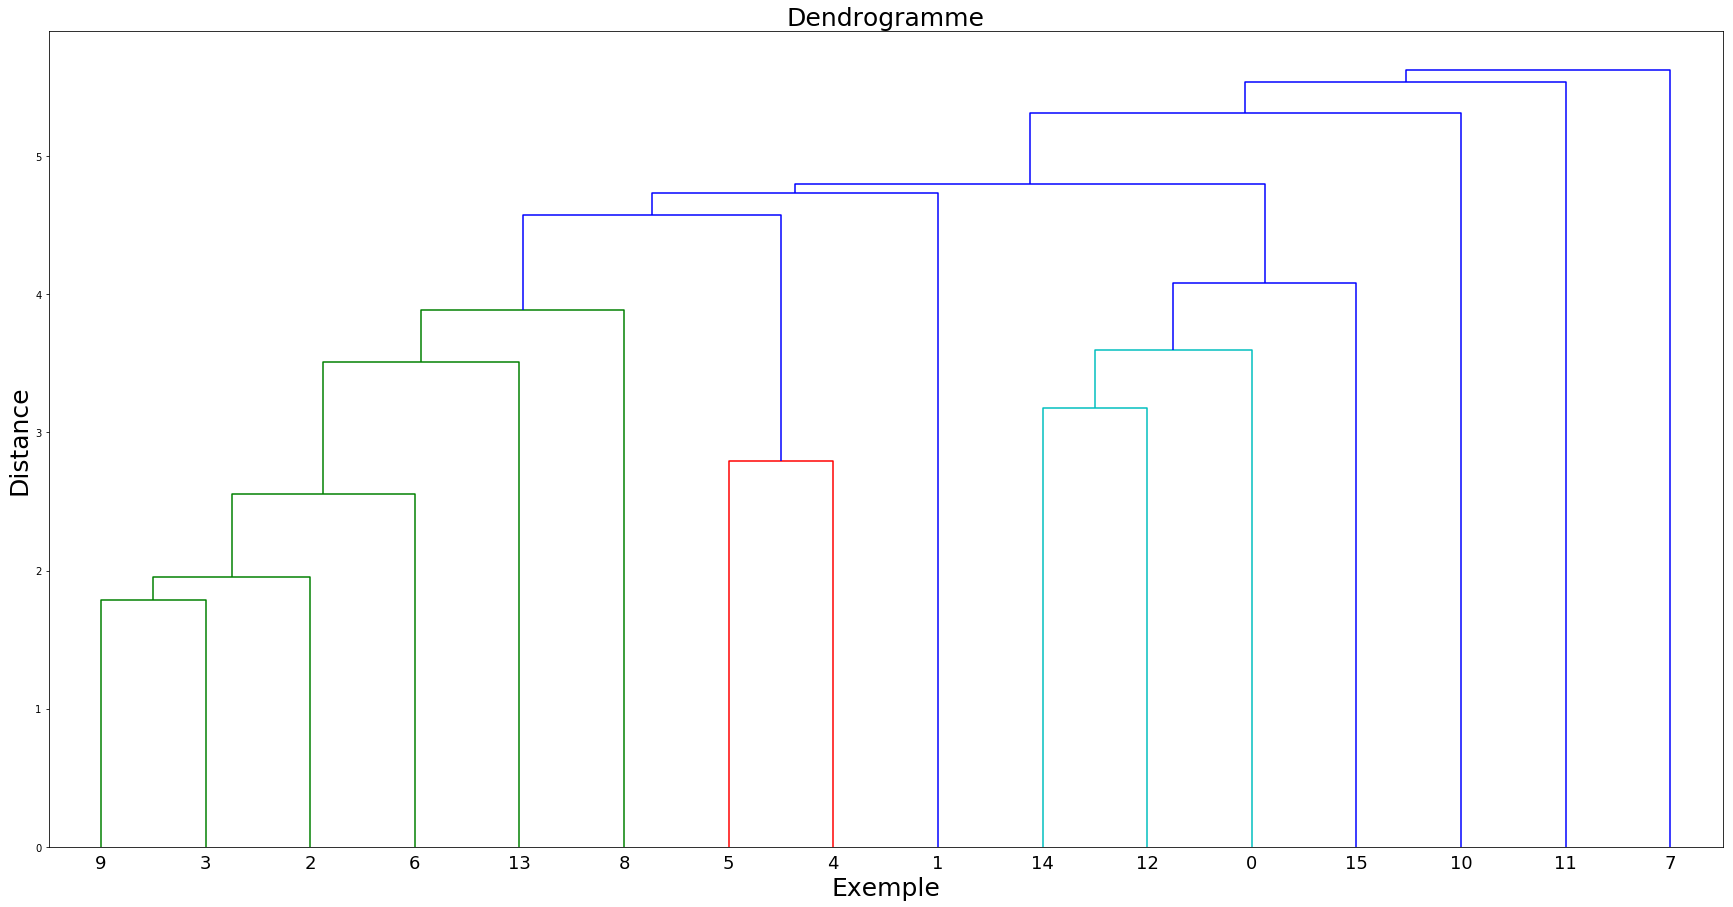

In [17]:
ct.dendogramme(M_Fusion)

In [18]:
"""
Fonction retournant le ou les categories correspondant
à chaque centroide
centroide: dataframe, contient les categories et leur distance par rapport au centroide
seuil: float, définit le niveau d'affectation des categories dans les centroides, compris entre 0 et 1
"""
def affinite(centroide, seuil=1.0):
    final = {}
    for i in range(len(centroide)):
        inter = []
        for k in list(centroide):
            if centroide.iloc[i][k] >= seuil:
                inter.append(k)
        final[i] = inter
    return final

In [25]:
affinite(centroide, 0.8)

{0: ['Thriller'],
 1: ['Comedy'],
 2: ['Comedy', 'Drama', 'Romance'],
 3: ['Comedy'],
 4: ['Drama'],
 5: ['Drama', 'Romance'],
 6: ['Comedy', 'Drama'],
 7: ['Family'],
 8: ['Comedy', 'Family'],
 9: ['Comedy', 'Romance'],
 10: ['Documentary'],
 11: [],
 12: ['Action', 'Thriller'],
 13: ['Comedy', 'Fantasy'],
 14: ['Crime', 'Thriller'],
 15: ['Drama', 'Mystery']}

<strong><font color="orange">[E]</font></strong> Les clusters obtenus nous permettent d'observer les catégories qui ont la même affinité. Pondérer cela avec les distances obtenues lors du clustering hierarchique nous permet de trouver une ou deux catégories capables d'être en commun avec d'autres catégories ne dépassant pas un certain seuil d'incompatibilité.

<strong><font color="purple">[R]</font></strong> On pourrait filtrer les films de départ afin de ne conserver que ceux suceptible de nous intéresser. Par exemple pour produire un film de nos jours dont la catégorie est suceptible de toucher le plus de publique entre 30 et 40 ans dans le marché Est asiatique, il serait plus judicieux de ne conserver que les films qui ont eu un succèes dans cette région et datant d'après l'année 2000

<strong><font color="green">[Q]</font></strong> Pourquoi ne pas avoir automatisé l'approfondissement ?<br/>
<strong><font color="green">[A]</font></strong> Le budget..